In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm_notebook as tqdm
import _pickle as pk

torch.manual_seed(1)
random.seed(1)

import copy, warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
config = {
    'num_train': 20000,
    'num_valid': 5000,
    'patience': 10,
    'batch': 32,
    'epoch': 1000,
    'lr': 0.001,
    'momentum': 0.99,
    'emb_size': 64,
    'lstm_size': 128,
    'pred_size': 10,
    'testfile': "../data/raw/test.txt",
    'logfile': "model_single_noattn.log",
    'lossfile': 'model_single_noattn.loss',
    'checkpoint': "model_single_noattn.pt"
}

open(config['logfile'], 'w').close()
def saveLogMsg(msg):
    print(msg, "\n")
    with open(config['logfile'], "a") as myfile:
        myfile.write(msg + "\n")
        
saveLogMsg("Initializing imports and config...")

Initializing imports and config... 



In [3]:
def sorting_letters_dataset(size):
    dataset = []
    for _ in range(size):
        x = []
        for _ in range(random.randint(3, 10)):
            letter = chr(random.randint(97, 122))
            repeat = [letter] * random.randint(1, 3)
            x.extend(repeat)
        y = sorted(set(x))
        dataset.append((x, y))
    return zip(*dataset)

train_inp, train_out = sorting_letters_dataset(config['num_train'])
valid_inp, valid_out = sorting_letters_dataset(config['num_valid'])

saveLogMsg("Dataset for train and valid...")

Dataset for train and valid... 



In [4]:
class Vocab:
    def __init__(self, vocab):
        self.itos = vocab
        self.stoi = {d:i for i, d in enumerate(self.itos)}
        
    def __len__(self):
        return len(self.itos) 

src_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)])
tgt_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)] + ['<start>', '<stop>'] )

START_IX = tgt_vocab.stoi['<start>']
STOP_IX  = tgt_vocab.stoi['<stop>']

saveLogMsg("Vocab for source and target...")

Vocab for source and target... 



In [5]:
def map_elems(elems, mapper):
    return [mapper[elem] for elem in elems]

def map_many_elems(many_elems, mapper):
    return [map_elems(elems, mapper) for elems in many_elems]

train_x = map_many_elems(train_inp, src_vocab.stoi)
train_y = map_many_elems(train_out, tgt_vocab.stoi)

valid_x = map_many_elems(valid_inp, src_vocab.stoi)
valid_y = map_many_elems(valid_out, tgt_vocab.stoi)

saveLogMsg("Mapping dataset through Vocab...")

Mapping dataset through Vocab... 



In [6]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, z_type, dropout=0.5):
        super(Encoder, self).__init__()
        self.z_index = z_type
        
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, lstm_size, batch_first=True)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, inputs):
        device = next(self.parameters()).device
        
        seq = torch.tensor([inputs]).to(device) # (1, seqlen)
        emb = self.emb(seq) # (1, seqlen, emb_dim)
        emb = self.drop(emb) 
        
        outs, (h_n, c_n) = self.lstm(emb)
        
        if self.z_index == 1:
            return h_n[0], c_n[0] # (seqlen, lstm_dim)
        else:
            return outs # (1, seqlen, lstm_dim)

encoder = Encoder(vocab_size=len(src_vocab), 
                  emb_dim=config['emb_size'], 
                  lstm_size=config['lstm_size'], 
                  z_type=1)
saveLogMsg("encoder:\n{}".format(encoder))

encoder:
Encoder(
  (emb): Embedding(27, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
) 



In [7]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, dropout=0.5):
        super(Decoder, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTMCell(emb_dim, lstm_size)
        self.clf = nn.Linear(lstm_size, vocab_size)
        
        self.drop = nn.Dropout(dropout)
        self.objective = nn.CrossEntropyLoss(reduction="none")
        
    def forward(self, state, targets, curr_token, last_token):
        device = next(self.parameters()).device
    
        loss = 0
        shifted = targets + [last_token]
        for i in range(len(shifted)):
            inp = torch.tensor([curr_token]).to(device)
            
            emb = self.emb(inp)
            emb = self.drop(emb)
            
            state = self.lstm(emb, state)
            q_i, _ = state 
            q_i = self.drop(q_i)

            scores = self.clf(q_i)
            target = torch.tensor([shifted[i]]).to(device)
            loss += self.objective(scores, target)
            
            curr_token = shifted[i]
            
        return loss / len(shifted)
    
    def predict(self, state, curr_token, last_token, maxlen):
        device = next(self.parameters()).device
        
        preds = []
        for i in range(maxlen):
            inp = torch.tensor([curr_token]).to(device)
            
            emb = self.emb(inp)
            
            state = self.lstm(emb, state)
            h_i, _ = state
            
            scores = self.clf(h_i)
            pred = torch.argmax(torch.softmax(scores, dim=1))
            curr_token = pred
            
            if last_token == pred:
                break
            preds.append(pred)
            
        return preds
    
    def evaluate(self, state, targets, curr_token, last_token):
        device = next(self.parameters()).device
        
        preds, loss = [], 0
        shifted = targets + [last_token]
        for i in range(len(shifted)):
            inp = torch.tensor([curr_token]).to(device)
            
            emb = self.emb(inp)
            
            state = self.lstm(emb, state)
            h_i, _ = state
            
            scores = self.clf(h_i)
            target = torch.tensor([shifted[i]]).to(device)
            loss += self.objective(scores, target)
            
            pred = torch.argmax(torch.softmax(scores, dim=1))
            curr_token = pred
            
            if last_token == pred:
                break
            preds.append(pred)
            
        return preds, loss
    
decoder = Decoder(vocab_size=len(tgt_vocab), 
                  emb_dim=config['emb_size'], 
                  lstm_size=config['lstm_size'])
saveLogMsg("decoder:\n{}".format(decoder))

decoder:
Decoder(
  (emb): Embedding(29, 64)
  (lstm): LSTMCell(64, 128)
  (clf): Linear(in_features=128, out_features=29, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (objective): CrossEntropyLoss()
) 



In [8]:
def map_prediction(sample_preds):
    sample_preds = [[tgt_vocab.itos[ix] for ix in each_preds] for each_preds in sample_preds]
    sample_preds = [''.join(each_preds) for each_preds in sample_preds]
    return sample_preds

def predict(encoder, decoder, sample_x, batch_size, pred_size):
    encoder.eval()
    decoder.eval()
    
    predictions = []
    with torch.no_grad():
        for i in range(len(sample_x)):
            x = sample_x[i]            
            x_preds = decoder.predict(encoder(x), START_IX, STOP_IX, pred_size)
            predictions.append(x_preds)
    
    predictions = map_prediction(predictions)
    return predictions

def evaluate(encoder, decoder, sample_x, sample_y, batch_size):
    encoder.eval()
    decoder.eval()
    
    predictions, sample_loss = [], 0.0
    with torch.no_grad():
        for i in range(len(sample_x)):
            x = sample_x[i]
            y = sample_y[i]
            
            x_preds, x_loss = decoder.evaluate(encoder(x), y, START_IX, STOP_IX)
            predictions.append(x_preds)
            sample_loss += x_loss.item()
    
    sample_loss = sample_loss / len(sample_x) * 1.0
    
    actuals = map_prediction(sample_y)
    predictions = map_prediction(predictions)
    
    accuracy = accuracy_score(actuals, predictions)
    return predictions, sample_loss, accuracy

def train(encoder, enc_optim, decoder, dec_optim, train_x, train_y, batch_size):
    encoder.train()
    decoder.train()

    train_x, train_y = shuffle(train_x, train_y)

    train_loss, batch_loss = 0.0, 0.0
    for i in range(len(train_x)):
        x = train_x[i]
        y = train_y[i]

        batch_loss += decoder(encoder(x), y, START_IX, STOP_IX)
        
        if (i+1) % batch_size or i == len(train_x) - 1:
            batch_loss.backward()
            enc_optim.step()
            dec_optim.step()

            encoder.zero_grad(); enc_optim.zero_grad()
            decoder.zero_grad(); dec_optim.zero_grad()

            train_loss += batch_loss.item()
            batch_loss = 0

    train_loss = train_loss / len(train_x) * 1.0
    
    return encoder, decoder, train_x, train_y, train_loss

In [9]:
def shuffle(x, y):
    pack = list(zip(x, y))
    random.shuffle(pack)
    return zip(*pack)

def track_best_model(encoder, decoder, epoch, best_acc, valid_acc, valid_loss, patience_track):
    if best_acc >= valid_acc:
        return best_acc, '', patience_track+1
    state = {
        'encoder': encoder.state_dict(), 
        'decoder': decoder.state_dict(),
        'acc': valid_acc,
        'loss': valid_loss,
        'epoch': epoch
    }
    torch.save(state, config['checkpoint'])
    return valid_acc, ' * ', 0

def load_best_model():
    encoder = Encoder(vocab_size=len(src_vocab), 
                  emb_dim=config['emb_size'], 
                  lstm_size=config['lstm_size'], 
                  z_type=1)
    decoder = Decoder(vocab_size=len(tgt_vocab), 
                  emb_dim=config['emb_size'], 
                  lstm_size=config['lstm_size'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    state = torch.load(config['checkpoint'], map_location=device)
    encoder.load_state_dict(state['encoder'])
    decoder.load_state_dict(state['decoder'])
    state = {'acc': state['acc'], 'loss': state['loss'], 'epoch': state['epoch']}
    return encoder, decoder, state

def training_loop(encoder, decoder, train_x, train_y, epochs, batch_size, print_every=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    encoder.to(device)
    decoder.to(device)

    enc_optim = optim.SGD(encoder.parameters(), lr=config['lr'], momentum=config['momentum'])
    dec_optim = optim.SGD(decoder.parameters(), lr=config['lr'], momentum=config['momentum'])
    
    best_acc = -1.0
    patience_track = 0
    keep_loss = [[], []] # [[train],[valid]]
    
    for epoch in range(1, epochs+1):
        encoder.zero_grad(); enc_optim.zero_grad()
        decoder.zero_grad(); dec_optim.zero_grad()
        
        encoder, decoder, train_x, train_y, train_loss = train(encoder, enc_optim, decoder, dec_optim, train_x, train_y, batch_size)
        _, valid_loss, valid_acc = evaluate(encoder, decoder, valid_x, valid_y, batch_size)
        best_acc, epoch_track, patience_track = track_best_model(encoder, decoder, epoch, best_acc, valid_acc, valid_loss, patience_track)
        
        keep_loss[0].append(train_loss)
        keep_loss[1].append(valid_loss)
        
        if epoch % print_every == 0:
            epoch_msg = 'Epoch {} - [TRAIN] Loss: {:.6f}'.format(epoch, train_loss)
            epoch_msg += ' [DEV] Loss: {:.6f}, Acc: {:.6f}'.format(valid_loss, valid_acc)
            saveLogMsg(epoch_msg + epoch_track)
            
        if patience_track == int(config['patience']):
            saveLogMsg('No accuracy improvment for {} consecutive epochs, stopping training...'.format(config['patience']))
            break
    
    best_encoder, best_decoder, _ = load_best_model()
    with open(config['lossfile'], 'wb') as lossfile:
        pk.dump(keep_loss, lossfile)
    
    return best_encoder, best_decoder, keep_loss

In [10]:
if True: #not os.path.exists(config['checkpoint']):
    saveLogMsg("Training with encoder and decoder...")
    training_loop(encoder, decoder, train_x, train_y, config['epoch'], config['batch'], print_every=1)
    saveLogMsg('Training done...')

Training with encoder and decoder... 

Epoch 1 - [TRAIN] Loss: 1.209665 [DEV] Loss: 2.607144, Acc: 0.792800 *  

Epoch 2 - [TRAIN] Loss: 0.321942 [DEV] Loss: 0.670059, Acc: 0.953600 *  

Epoch 3 - [TRAIN] Loss: 0.159884 [DEV] Loss: 0.285376, Acc: 0.982200 *  

Epoch 4 - [TRAIN] Loss: 0.102228 [DEV] Loss: 0.246820, Acc: 0.990400 *  

Epoch 5 - [TRAIN] Loss: 0.074495 [DEV] Loss: 0.151441, Acc: 0.993800 *  

Epoch 6 - [TRAIN] Loss: 0.065666 [DEV] Loss: 0.109548, Acc: 0.995600 *  

Epoch 7 - [TRAIN] Loss: 0.054278 [DEV] Loss: 0.125623, Acc: 0.994800 

Epoch 8 - [TRAIN] Loss: 0.043075 [DEV] Loss: 0.117963, Acc: 0.995000 

Epoch 9 - [TRAIN] Loss: 0.045605 [DEV] Loss: 0.273130, Acc: 0.991000 

Epoch 10 - [TRAIN] Loss: 0.042975 [DEV] Loss: 0.028969, Acc: 0.997600 *  

Epoch 11 - [TRAIN] Loss: 0.041695 [DEV] Loss: 0.046155, Acc: 0.998200 *  

Epoch 12 - [TRAIN] Loss: 0.043980 [DEV] Loss: 0.101321, Acc: 0.998000 

Epoch 13 - [TRAIN] Loss: 0.034407 [DEV] Loss: 0.092175, Acc: 0.995800 

Epoch 14 -

In [11]:
keep_loss = [[], []] # [[train],[valid]]
if os.path.exists(config['checkpoint']):
    with open(config['lossfile'], 'rb') as lossfile:
        keep_loss = pk.load(lossfile)
    encoder, decoder, state = load_best_model()
    saveLogMsg('Returning best model from epoch {} with loss {:.6f} and accuracy {:.6f}.'.format(state['epoch'], state['loss'], state['acc']))    

Returning best model from epoch 34 with loss 0.002141 and accuracy 0.999600. 



Retrieving training and validation loss... 



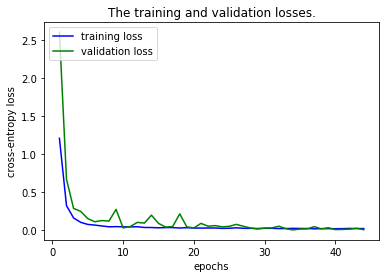

In [12]:
saveLogMsg('Retrieving training and validation loss...')

keep_loss = [[], []] # [[train],[valid]]
with open(config['lossfile'], 'rb') as lossfile:
    keep_loss = pk.load(lossfile)

# Refs: https://matplotlib.org/tutorials/introductory/pyplot.html
import matplotlib.pyplot as plt
%matplotlib inline

epochs = [i for i in range(1, len(keep_loss[0])+1)]
plt.plot(epochs, keep_loss[0], 'b', label="training loss")
plt.plot(epochs, keep_loss[1], 'g', label="validation loss")
plt.legend(loc="upper left")
plt.xlabel('epochs')
plt.ylabel('cross-entropy loss')
plt.title('The training and validation losses.')
plt.show()

In [13]:
saveLogMsg("Loading test dataset from {}.".format(config['testfile']))

test_inp, test_out = [], []
with open(config['testfile'], 'r') as testfile:
    for eachline in testfile:
        eachline = eachline.strip()
        if eachline:
            eachline = eachline.split()
            if len(eachline) == 2:
                test_inp.append(eachline[0])
                test_out.append(eachline[1])
test_x = map_many_elems(test_inp, src_vocab.stoi)
test_y = map_many_elems(test_out, tgt_vocab.stoi)    

Loading test dataset from ../data/raw/test.txt. 



In [14]:
def getAccuracyScore(encoder, decoder, sample_x, sample_out):
    predictions = predict(encoder, decoder, sample_x, config['batch'], config['pred_size'])
    groundtruth = [''.join(str_y) for str_y in sample_out]
    acc = accuracy_score(groundtruth, predictions)
    return acc

saveLogMsg("Test accuracy score = {}".format(getAccuracyScore(encoder, decoder, test_x, test_out)))

Test accuracy score = 0.924 

